In [1]:
import mxnet as mx

from mxboard import SummaryWriter
from mxnet import Context, cpu, gpu
from mxnet.ndarray import concat, clip
from tqdm import tqdm
 
from discriminator_6frames import Discriminator
from generator_6frames_simple import Generator

from util import Device
import matplotlib.pyplot as plt 
import numpy as np
from mxnet.io import NDArrayIter
import os

import generator_6frames as gen
import generator_6frames_simple as dis
import time
from glob import glob
from mxnet.ndarray import stack
import mxnet.gluon
import modules_simple as  modules

In [2]:
runname = f'RECON'
device = Device.GPU1
batch_size = 4
in_chan = 18
epoch = 6

In [3]:
context = cpu() if device.value == -1 else gpu(device.value)

with Context(context):

    test_iter = modules.make_video_iterator('testing', 'V1', 'V2', 'V3', batch_size=batch_size, shuffle=True)

    RFlocs_V1_overlapped_avg = modules.get_RFs('V1', context)
    RFlocs_V2_overlapped_avg = modules.get_RFs('V2', context)
    RFlocs_V3_overlapped_avg = modules.get_RFs('V3', context)

    generator = gen.Generator(in_chan, context)
    generator.network.load_parameters(f'saved_models/{runname}/netG_{epoch}.model', ctx=context) 
    g = generator.network
    outputs_lst = []
    targets_lst = []
    inputs_lst = []




## forward pass

In [4]:
for RFsignalsV1, RFsignalsV2, RFsignalsV3, targets, recon in tqdm(test_iter):
    with Context(context):

        # -----
        # Inputs
        # -----
        inputsV1 = modules.get_inputsROI(RFsignalsV1, RFlocs_V1_overlapped_avg, context)
        inputsV2 = modules.get_inputsROI(RFsignalsV2, RFlocs_V2_overlapped_avg, context)
        inputsV3 = modules.get_inputsROI(RFsignalsV3, RFlocs_V3_overlapped_avg, context)

        inputs = concat(inputsV1, inputsV2, inputsV3, recon.as_in_context(context), dim=1)

        outputs = generator.network(inputs)
        targets = targets.transpose((0,1,4,2,3)).reshape((-1,18, 96,96)).as_in_context(context)

    outputs_np = outputs.asnumpy()
    targets_np = targets.asnumpy()
    inputs_np = inputs.asnumpy()

    #         outputs_np = np.clip(255 * outputs, 0, 255).
    #         targets_np = np.clip(255 * targets, 0, 255)

    outputs_lst.append(outputs_np)
    targets_lst.append(targets_np)
    inputs_lst.append(inputs_np)

100%|██████████| 258/258 [00:07<00:00, 36.22it/s]


## concatenate all batches

In [10]:
outputs_concat = np.concatenate(outputs_lst)
targets_concat = np.concatenate(targets_lst)
inputs_concat = np.concatenate(inputs_lst)

## visualize some images

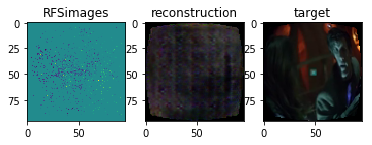

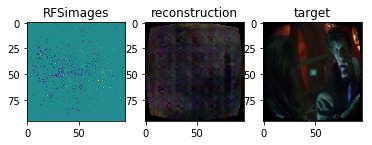

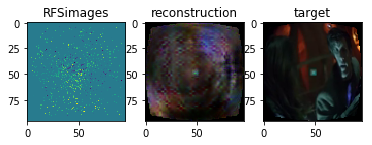

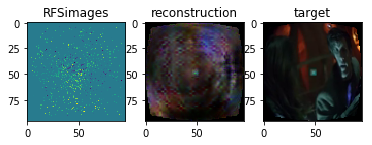

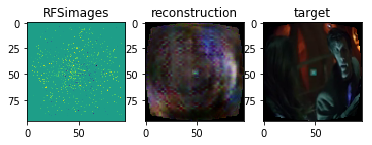

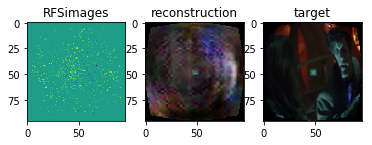

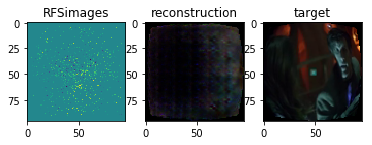

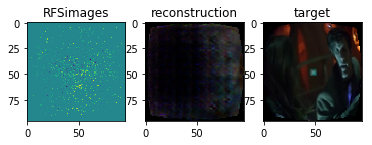

In [26]:
for b in range(4):
    for frames in range(2):
        o = outputs_concat.reshape(-1, 6, 3, 96 ,96 )[b][frames]
        y = targets_concat.reshape((-1,3,96,96))[b]

        plt.subplot(1,3,1)
        plt.imshow(inputs_concat[b][0])
        plt.title('RFSimages')
        plt.subplot(1,3,2)
        plt.imshow(o.transpose((1,2,0)))
        plt.title('reconstruction')
        plt.subplot(1,3,3)
        plt.imshow(y.transpose((1,2,0)))
        plt.title('target')
        plt.show()

### Save the reconstructions, run the following

In [ ]:
np.savez_compressed(f'../final_reconstructions/{runname}_epoch1', inputs = inputs, targets = targets, outputs = outputs)

## saving as videos (mp4) files

In [21]:
print(outputs_concat.shape,
targets_concat.shape,
inputs_concat.shape)

(1030, 18, 96, 96) (1030, 18, 96, 96) (1030, 18, 96, 96)


In [22]:
out_video_np = (outputs_concat.reshape(-1, 3, 96, 96)*255).transpose((0,2,3,1)).astype('uint8')
print(out_video_np.shape)

target_video_np = (targets_concat.reshape(-1, 3, 96, 96)*255).transpose((0,2,3,1)).astype('uint8')
print(target_video_np.shape)

inputs_video_np = np.expand_dims(inputs_concat.mean(1), 3).repeat(3,3).repeat(6,0).astype('uint8')
print(inputs_video_np.shape)

whole_video = np.concatenate((inputs_video_np, out_video_np, target_video_np), axis = 2)
print(whole_video.shape)

(6180, 96, 96, 3)
(6180, 96, 96, 3)
(6180, 96, 96, 3)
(6180, 96, 288, 3)


In [1]:
# !mkdir result_videos

In [24]:
import imageio

imageio.mimwrite(f'result_videos/whole_video_ep{epoch}_{runname}.mp4', whole_video)
